# Анализ рынка видео-игр

Необходимо проанализировать данные за период до 2016 года, из открытых источников. Доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 

Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Описание данных

/datasets/games.csv

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Примечание: Данные за 2016 год - не полные!

## 1. Предварительный анализ данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly
import plotly.express as px
import warnings
from scipy import stats as st

warnings.filterwarnings('ignore')
sns.set(style = 'darkgrid')
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [2]:
games_data = pd.read_csv('/datasets/games.csv')

In [3]:
games_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


На входе имеется датасет из 16к игр, с основной информацией о них. 
1. В некоторых столбцах присутствуют пропуски. Особенно много пропусков в столбцах Critic_Score, User__Score, Rating. Вероятно, в источнике данных об оценках игры и рейтинге, не хватало информации.
2. В некоторых столбцах не верный тип данных - например Year_of_Release должен быть по идее datetime (или Int), User_score должен быть числовым и др.

Поэтому для дальнейшего анализа необходимо сперва подготовить данные.

## 2. Предобработка данных

In [4]:
# переименуем столбцы по нижнему регистру. Руками, чтобы не пропустить возможные пробелы:))
games_data.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']

In [5]:
# подсчёт пропусков в столбце
def na_count(col):
    return games_data[col].isna().sum()

#### Название игры ('name')

В столбце есть 2 пропуска имени. Удалим эти строки.
Также, есть много дублирующихся названий. Но анализ этих данных показал, что это записи одной и той же игры для разных платформ. В некоторых случаях, если игра переиздавалсь, имя так же может совпадать. 

In [6]:
games_data.dropna(subset=['name'], inplace=True)

#### Платформа ('platform')

Данные по платформам выглядят валидно.

#### Год выпуска ('year_of_release')

Данные в этом столбце не в правильном формате, также присутствует 269 пропущенных значений.

In [7]:
na_count('year_of_release')

269

Год выхода оставим целочисленным параметром, т.к. нам достаточно года выхода (другие данные datetime без надобности). А пропуски просто удалим. 269 записей - это около 1.5% наших данных, не так много, а год выпуска игры нам важен. 

In [8]:
games_data.dropna(subset=['year_of_release'], inplace=True)
games_data['year_of_release'] = games_data['year_of_release'].round(0).astype('int')

#### Жанр ('genre')

In [9]:
na_count('genre')

0

In [10]:
games_data['genre'].value_counts()

Action          3307
Sports          2306
Misc            1721
Role-Playing    1481
Shooter         1296
Adventure       1293
Racing          1226
Platform         878
Simulation       857
Fighting         837
Strategy         673
Puzzle           569
Name: genre, dtype: int64

Довольно мало жанров, как для современной игровой индустрии. Но в целом данные выглядят валидными.

#### Продажи ('na_sales', 'eu_sales', 'jp_sales', 'other_sales')

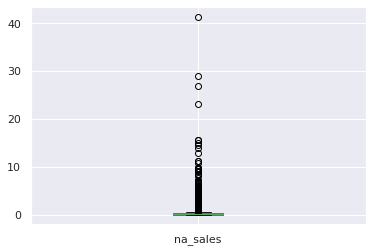

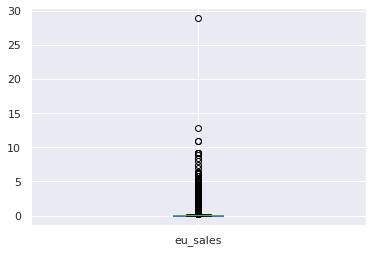

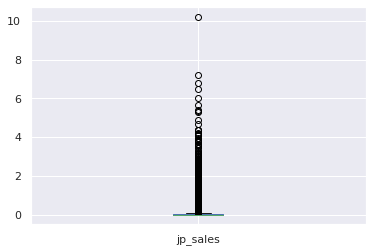

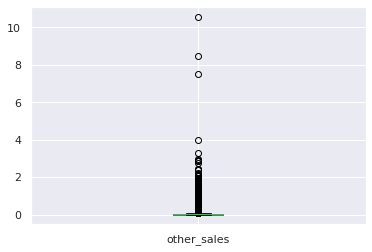

In [11]:
# посмотрим на значения в столбцах продаж
for i in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']:
    games_data[i].plot(kind='box')
    plt.show()

Большинство игр продаются небольшим тиражом (~ до 2 млн.$), но есть блокбастеры, в которые играют миллионы людей. 
Посмотрим что это за игры, чтобы убедиться в отсутствии ошибок в данных.

In [12]:
games_data.query('na_sales > 20')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Старые добрые игры на Денди! Кайф! Хотя с популярностью WiiSports даже они не сравнятся. В США, по крайней мере.

#### Оценки критиков и пользователей ('critic_score', 'user_score')

In [13]:
na_count('critic_score')

8461

In [14]:
na_count('user_score')

6605

В столбцах с оценками критиков и пользователей имеем довольно большое кол-во пропущенных значений. Вероятно это связано с тем, что источник данных не имел оценок по этим играм. Заполнить их не представляется возможным, т.к. рейтинг может очень отличаться для разных игр. Пропуски мы оставим.

Формат float в данных столбцах нас устраивает. Однако у пользовательского рейтинга тип данных - строка.
Посмотрим на значения.

In [15]:
games_data['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
9.6       2
0.2       2
1.5       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

Понятно. Многие игры не имеют рейтинга, вместо них аббревиатура tbd - To Be Determined. Вероятно, на момент выгрузки по части игры ещё не было данных о пользовательском рейтинге. Оставлять строковые значения в столбце с числами - не круто. Заменить tbd на что-то осмысленное мы тоже не можем - не знаем рейтингов игр. 

Поэтому будем считать, что tbd в нашем случае означает отсутствие данных по рейтингу. Чтобы отразить это, заменим значения на пропуски.

In [16]:
# заменяем tbd на пропуски NaN
games_data.loc[games_data['user_score'] == 'tbd', 'user_score'] = np.nan

# переведём данные в тип float и сбросим индексы
games_data['user_score'] = games_data['user_score'].astype('float', errors='ignore')
games_data.reset_index(inplace=True, drop=True)

#### Возрастной рейтинг ('rating')

In [17]:
# глянем на значения в столбце
games_data['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64

Я не специалист в возрастных рейтингах, но выглядит нормально.

Вот только рейтинг RP - это "Rating Pending", т.е. рейтинга нет ещё. Заменим это одно значение на nan.

In [18]:
games_data.loc[games_data['rating'] == 'RP', 'rating'] = np.nan

### Вывод

По результатам предобработки, получилась итоговая таблица с 16444 записей. 

Где это было возможно, пропуски были обработаны. Также данные были приведены к ожидаемым форматам.

## 3. Исследовательский анализ 

#### Задача 1: Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [19]:
# функция суммирования продаж по всем регионам
def total_sales(row):
    total_sales = row['na_sales'] + row['eu_sales'] + row['jp_sales'] + row['other_sales']
    return total_sales

In [20]:
# применяем функцию построчно
games_data['total_sales'] = games_data.apply(total_sales, axis = 1)

Суммарные продажи записаны в столбец "total_sales".

---

#### Задача 2: Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [21]:
# сделаем функцию, которая построит нужные нам графики
def plot_by_year(df, col, func='count', title=''):    
    plot_df = (df
               .pivot_table(index='year_of_release', values=col, aggfunc=func)
               .reset_index()
               .sort_values('year_of_release', ascending=True)
              )
    
    ax = plot_df.plot(
        x='year_of_release',
        y=col, 
        kind='line',
        marker='o',
        figsize=(15,8),
        label=('{} {}'.format(col,func)),
        grid=True)
    
    ax.set_title(title)

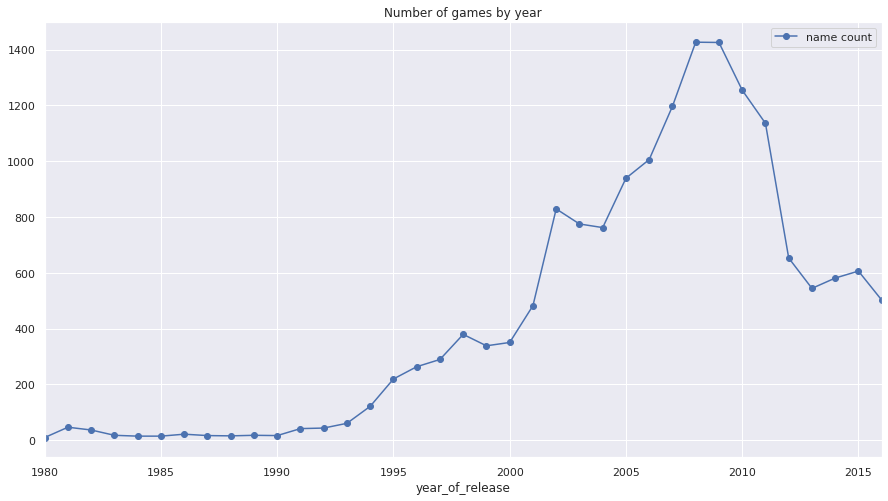

In [22]:
plot_by_year(games_data, 'name', title='Number of games by year')

На графике видно, что взрывной рост игровой индустрии начался в 2000 году. Пик по количеству выпущенных игр пришолся на 2008-2009 год. После этого, игр стало выпускаться меньше.

Игровая индустрия довольно динамичный рынок, где тренды сменяют друг друга часто. Вспомнить хотя бы появление Minecraft, после чего (и до сих пор) выходит 100500 игр про выживание. Или выход PUBG - в результате все сейчас играют в "королевские битвы".
К жанрам мы ещё вернёмся. 

---
#### Задача 3: Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Определим топ-5 платформ по суммам продаж.

In [23]:
top5_platforms = (games_data
                 .pivot_table(index='platform', values='total_sales', aggfunc='sum')
                 .sort_values('total_sales', ascending=False)
                 .reset_index()
                 .head(5)['platform']
                )
top5_platforms

0     PS2
1    X360
2     PS3
3     Wii
4      DS
Name: platform, dtype: object

Теперь посмотрим распределение продаж по годам для каждой платформы из списка топ-5.

In [24]:
# при анализе обнаружился один выброс в 1985 году, очевидно ошибка. Мы бы и так избавились от него дальше в работе,
# но исключим его здесь, чтобы не портить графики
games_data=games_data.drop(15704)

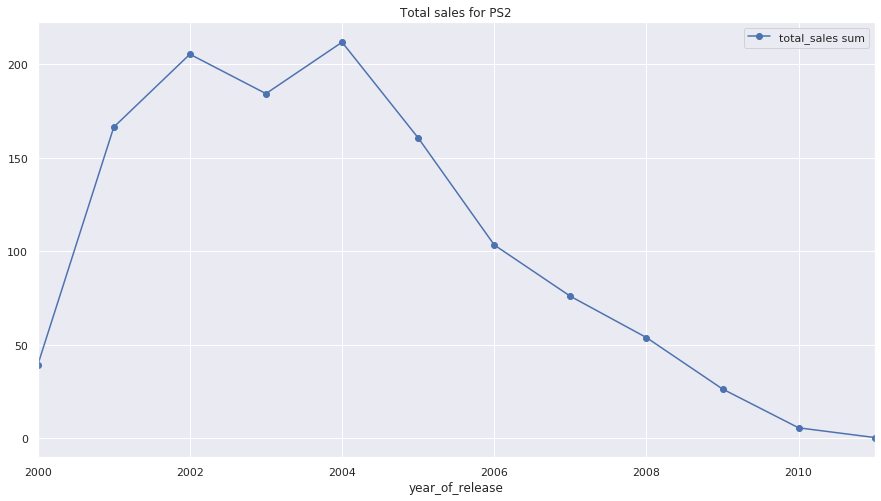

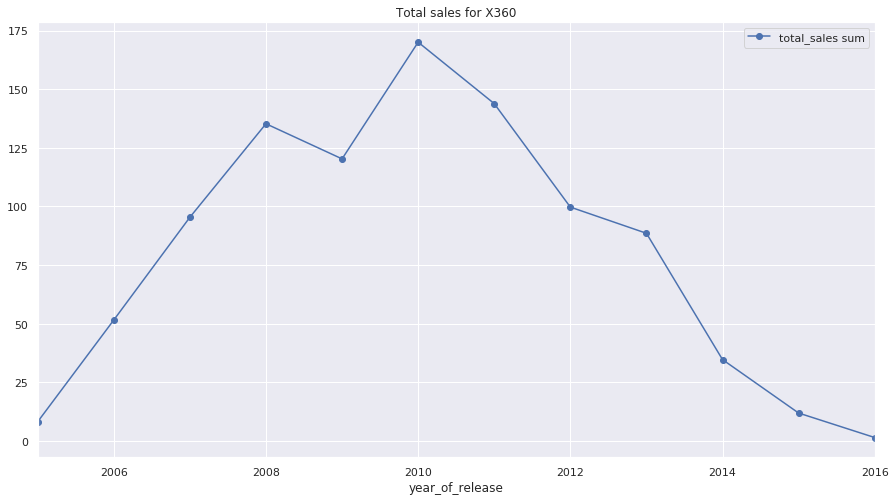

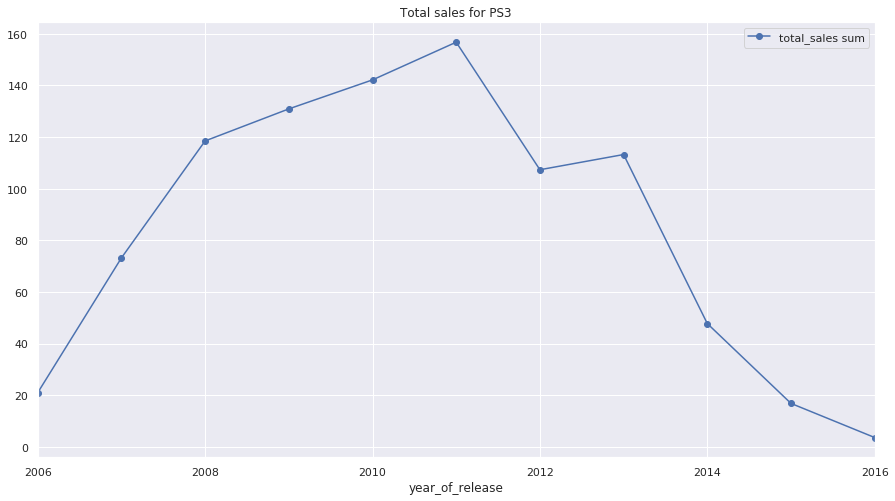

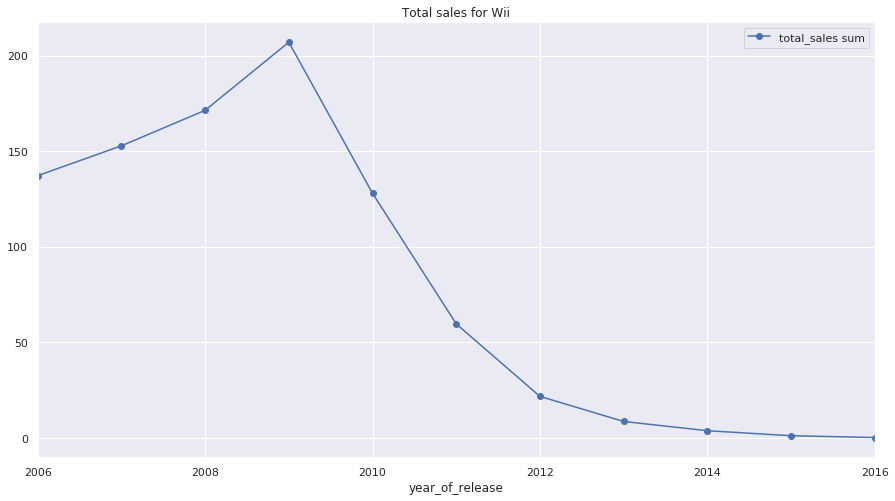

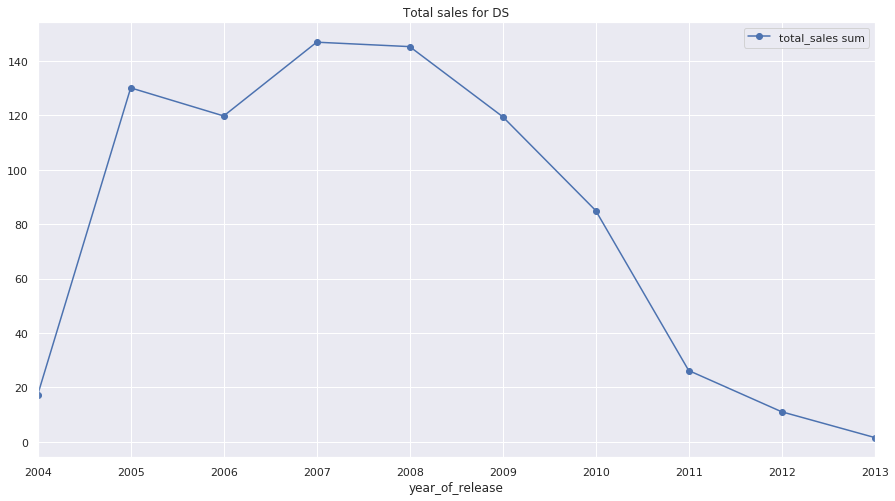

In [25]:
# применим нашу функцию 
for each in top5_platforms:
    plot_df = games_data.query('platform == @each')
    plot_by_year(df=plot_df, col='total_sales', func='sum', title='Total sales for {}'.format(each))

### Графики в целом выглядят похожими. Можно сделать следующие выводы:
* Средний жизненный цикл платформы составляет 10 лет. 
* Первые 1-2 года новая платформа набирает популярность, продажи растут.
* После этого 4-5 лет - период основного присутствия платформы на рынке, игр выпускается много, продажи стабильно высокие.
* На заключительном этапе ЖЦ платформы (3-4 года) продажи падают.

Посмотрим, а как распределяется кол-во игр, выпускаемых для платформы на разных этапах её ЖЦ.
Для примера, посмотрим по 3м самым популярным - X-Box 360, PS2 и PS3.

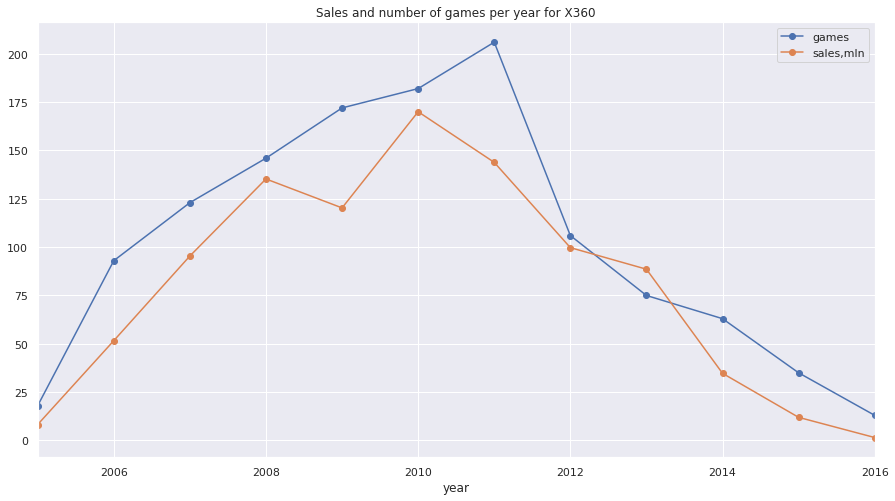

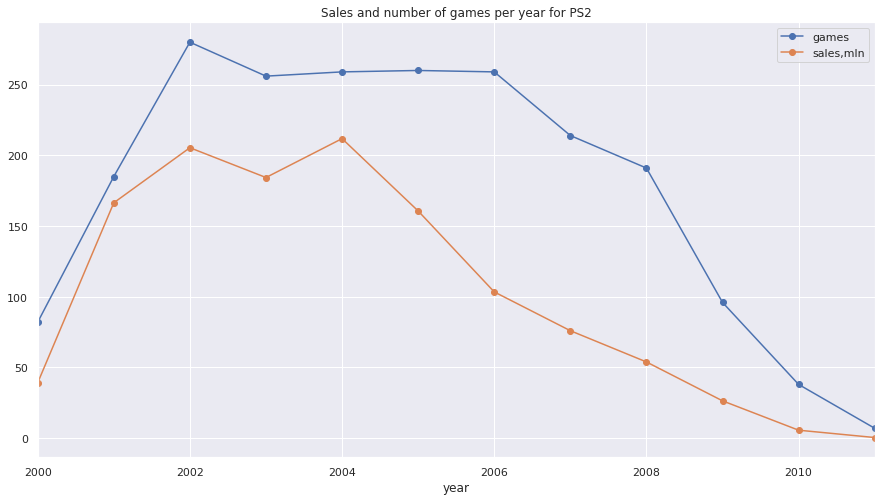

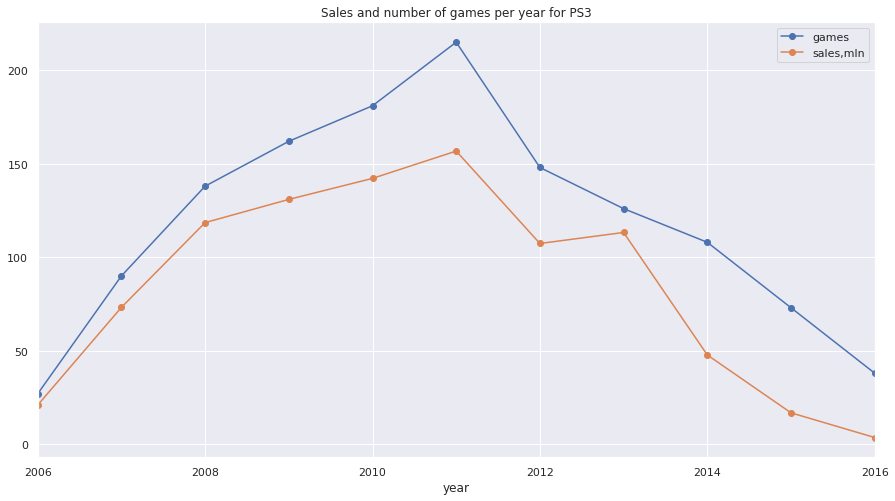

In [26]:
# построим быстренько графики, возьмём выборки по трем платформам
for each in ['X360', 'PS2', 'PS3']:
    plot_df = (games_data
               .query('platform == @each')
               .pivot_table(index='year_of_release', values=('total_sales'), aggfunc=('count', 'sum'))
               .sort_values('year_of_release', ascending=True)
               .reset_index()
              )
    
    #count = количество игр, sum = продажи
    plot_df.columns=['year', 'games', 'sales,mln']
    
    # т.к. величины продаж в миллионах и количество выпущенных игр у нас одного порядка, построим их на одном графике
    # для наглядности распределения по годам
    ax=plot_df.plot(
        kind='line',
        x='year', 
        y=['games', 'sales,mln'],
        marker='o',
        figsize=(15,8),
        grid=True
    )
    ax.set_title('Sales and number of games per year for {}'.format(each))

Выводы из графиков:
1. Платформа выходит на пик продаж игр, примерно через 4 года после старта продаж.
2. Так же, примерно через 4 года после выхода платформы, выпускается наибольшее кол-во игр. 
3. Доходы и кол-во выпускаемых игр драматически снижается через ~7-8 лет после выхода платформы.

---
#### Задача 4. Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

Отметим, что при прогнозировании продаж на таком изменчивом рынке, как игровой, стоит ориентироваться на как можно более свежие данные и тренды. Учитывая, средний ЖЦ платформы в 10 лет, а период основного присутствия 4-5 лет, необходимо подобрать период рассмотрения так, чтобы охватить в 2017 году наиболее актуальные игры и платформы.

Т.к. "заключительный" этап ЖЦ платформы длится 2-3 года, можно с уверенностью сказать, что нас не интересуют платформы, для которых не выходило новых игр больше этого срока.

Таким образом можно сформулировать критерии выбора наиболее актуальных платформ:

<b>1. Последняя игра для платформы выходила не позже 2 лет назад - отсеиваем совсем не актуальные, не попадаем в заключительный этап ЖЦ по выпуску игр.
2. Продажи по платформе не падают более 3 лет - т.е. ищем период "основного присутствия".
</b>

Посмотрим какие платформы соответствуют этим критериям.

In [27]:
# посмотрим какие платформы соответствуют первому критерию
not_old_platforms = games_data.query('year_of_release >= 2015')['platform'].unique()
not_old_platforms

array(['PS4', 'XOne', '3DS', 'WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV',
       'PSP'], dtype=object)

In [28]:
#возьмём данные по играм, выпущенными за последние 10 лет(период актуальности платформы), и только для неустаревших платформ
hot_games = games_data.query('(platform in @not_old_platforms) & (year_of_release >= 2006)')

In [29]:
hot_platforms = hot_games['platform'].unique()
print('Список актуальных платформ:', hot_platforms)
print('Количество игр для них во входных данных:', hot_games['name'].count())

Список актуальных платформ: ['Wii' 'X360' 'PS3' 'PS4' '3DS' 'PC' 'XOne' 'WiiU' 'PSP' 'PSV']
Количество игр для них во входных данных: 7392


Получается, что на 2016 год актуальны 10 платформ (по первому критерию). И у нас имеются данные по 7392 играм для них.

В дальнейшем исследовании мы будем использовать только эти игры, как более-менее актуальную выборку.

Однако мы проверили лишь один критерий из определённых выше: игры для платформы выпускались за последние 2 года. 

Посмотрим что по второму критерию: отсутствию устойчивого падения продаж за последние 3 года.

---

#### Задача 5:	Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

In [30]:
# посмотрим информацию о сумме продаж по актуальным платформам
hot_games.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
X360    952.99
PS3     931.34
Wii     891.18
PS4     314.14
3DS     257.81
PSP     238.63
PC      163.42
XOne    159.32
WiiU     82.19
PSV      53.81
Name: total_sales, dtype: float64

Лидеры и отстающие понятны.

Оценим, на каких платформах был замечен рост продаж за последние 3 года (с 2014 включительно). Это будет означать, что на таких платформах не было устойчивого падения последние 3 года подряд (проверка 2го критерия).

In [31]:
# массив для результата
perspective_platforms = []

# перебираем список не устаревших платформ
for each in hot_platforms:
    plot_df = (hot_games
               .query('platform == @each')
               .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
               .reset_index()
               .sort_values('year_of_release', ascending=True)
              )
    # оцениваем разницу доходности года с предыдущим
    for i in range(2014,2017):
        try:
            annual_sales = plot_df.query('year_of_release == @i').reset_index().iloc[0]['total_sales']
            last_sales = plot_df.query('year_of_release == (@i - 1)').reset_index().iloc[0]['total_sales']
            dif = annual_sales.item() - last_sales.item()
            #если замечен рост доходов - запишем на какой платформе
            if dif > 0:
                perspective_platforms.append(each)
        # т.к. у нас данные могут быть не за все рассматрвиаемые года, оценим были ли ошибки
        except:
            print(each, i)

PSP 2016


Ошибка возникла только по одной платформе для 2016 года - это связано с тем, что для данной платформы нет ни одной выпущенной игры в 2016 году. Значит она нам не подходит.

In [32]:
# посмотрим список получившихся платформ по обоим критериям
platforms_set = set(perspective_platforms)
platforms_set

{'PC', 'PS4', 'PSV', 'WiiU', 'XOne'}

Получили 5 платформ, удовлетворяющих выбранным нами критериям.
Проверим визуально, как выглядят продажи на этих платформах по известным нам данным (за последние 10 лет).

In [33]:
# функция для построения графиков на одной оси
def sales_by_year_plot(df, col, func='sum', title=''):
    plt.figure(figsize=(17,8))
    for each in platforms_set:
        plot_df = (df
                   .query('platform == @each')
                   .pivot_table(index='year_of_release', values=col, aggfunc=func)
                   .reset_index()
                   .sort_values('year_of_release', ascending=True)
                  )
        ax=sns.lineplot(
            data=plot_df,
            x='year_of_release',
            y=col,
            label=each,
            marker='o',
        )
        ax.set_title(title)
        ax.set_xlabel('YEAR')
    plt.legend()
    plt.show()

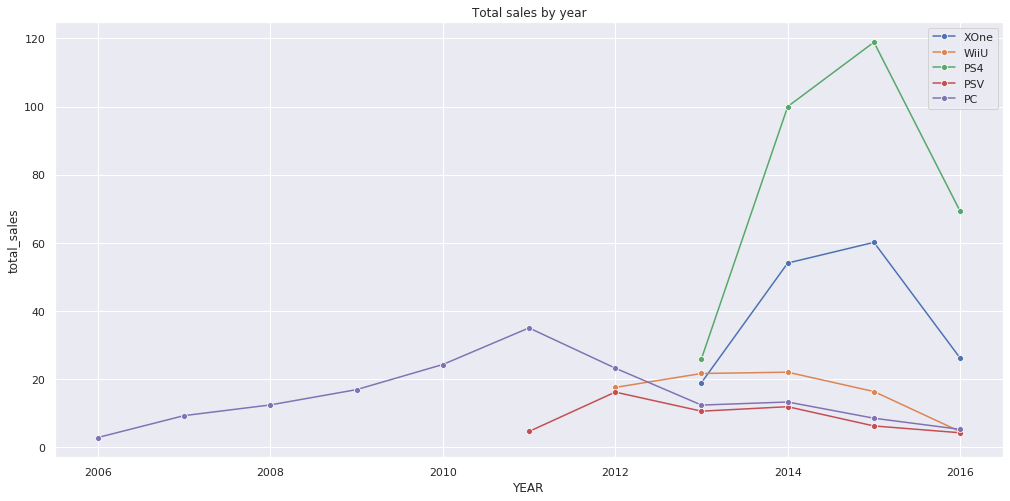

In [34]:
sales_by_year_plot(hot_games, 'total_sales', title='Total sales by year')

Так как данные по играм за 2016 год не полные, мы видим просадку по продажам по всем платформам. Но анализируя информацию по предыдущим годам, можно сделать следующие выводы:
* Наиболее перспективными и новыми являются платформы PS4 и XOne. Они находятся в начале своего жизненного цикла, а значит продажи на этих платформах вероятно будут ещё расти.
* Продажи игр для PSV и WiiU достаточно стабильны. Вероятно, они будут оставаться на таком же уровне (или будут падать) ещё несколько лет.
* Несмотря на падение продаж игр для PC, рост продаж в 2014 году не позволил нам отсечь эту платформу. Будем надеяться, что ПеКа гейминг ещё вернётся в 2017 году!

#### Задача 6: Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

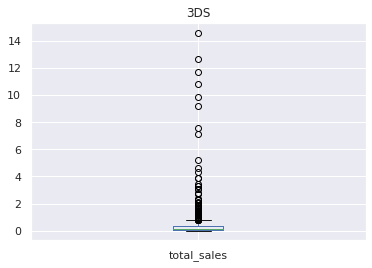

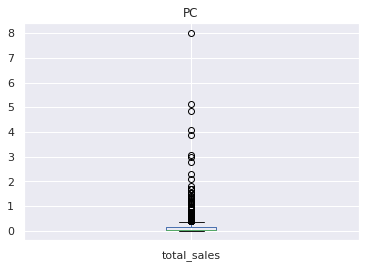

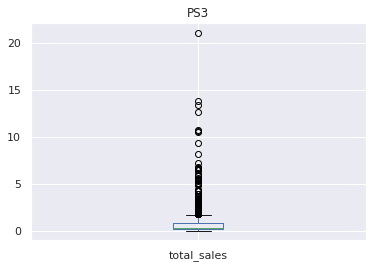

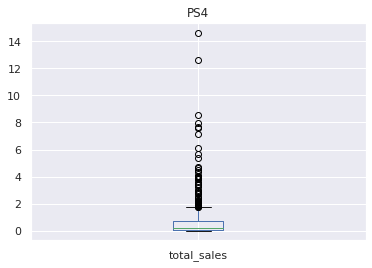

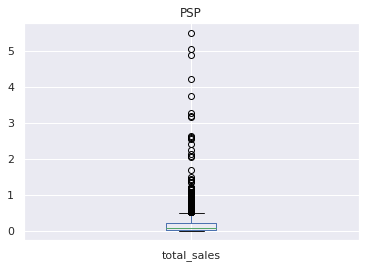

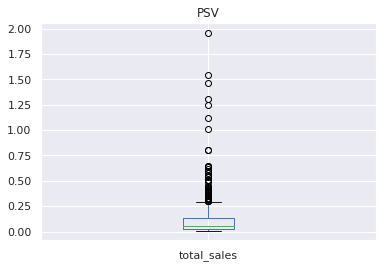

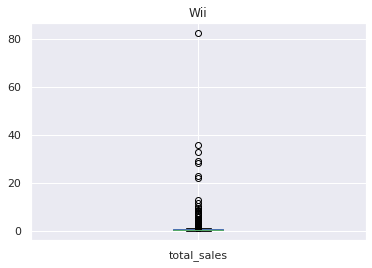

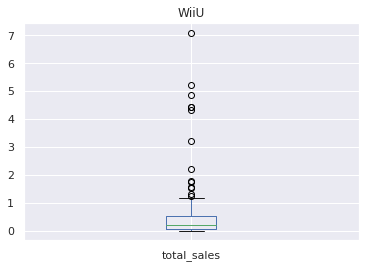

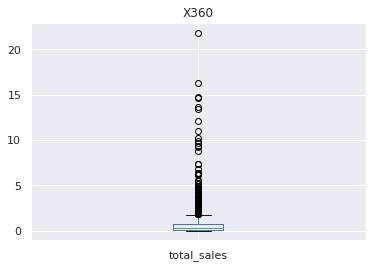

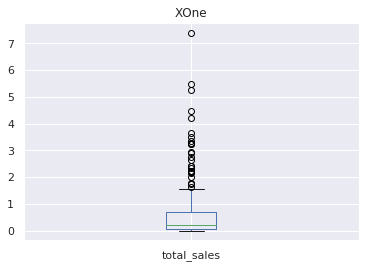

In [35]:
for index, group in hot_games.groupby('platform'):
    group['total_sales'].plot(kind='box', title=index)
    plt.show()

Графики "ящики с усами" построены. Зачем это было нужно в задании и какие выводы из этого можно было бы сделать(применительно к исследованию) - не понятно. Графики не очень наглядны.

Точнее единственный полезный вывод, который можно сделать - подавляющее большинство игр продаётся менее чем на 2 млн.$.

---
#### Задача 7: Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Для анализа выберем платформу X360, как наиболее популярную из нашей выборки "горячих" игр.

In [36]:
x360_games = hot_games.query('platform == "X360"')

In [37]:
#посмотрим матрицу корреляции для продаж и оценок критиков и пользователей
x360_games[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.396307,0.115762
critic_score,0.396307,1.000000,0.622629
user_score,0.115762,0.622629,1.000000


1. Видна сильная прямая зависимость продаж от оценки критиков (r=0.4).
2. А вот зависимость продаж от оценки пользователей существенно меньше (r=0.12)
3. Примечательно, что зависимость между оценками пользователей и критиков ещё выше(r=0.6), но это в целом понятно.

Построим графики распределния продаж, в зависимости от оценок критиков и пользователей.
Для наглядности, рассматривать будем игры, проданные менее чем на 5 млн - как мы выяснили, в это окно укладывается 99% игр.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


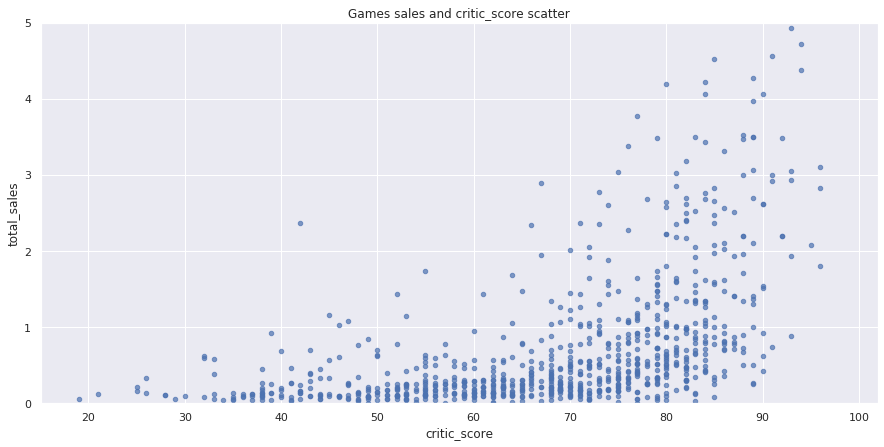

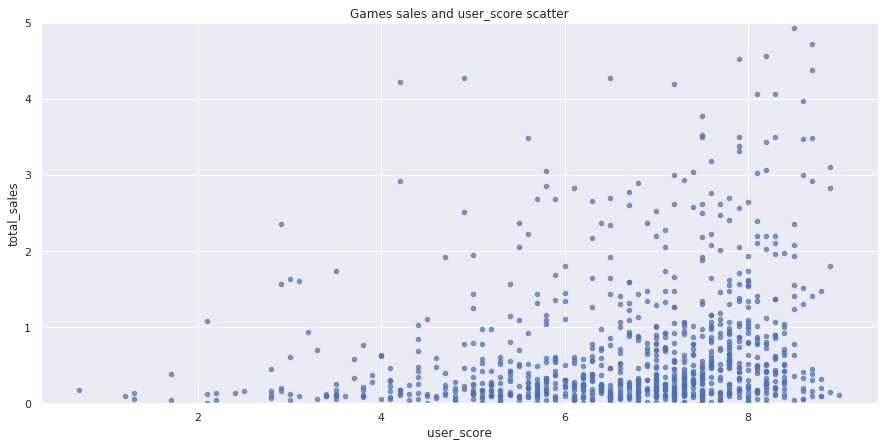

In [38]:
for each in ['critic_score', 'user_score']:
    x360_games.plot(
        x=each,
        y='total_sales',
        kind='scatter',
        figsize=(15,7),
        alpha=0.7,
        ylim=(0,5),
        title='Games sales and {} scatter'.format(each))

Можно сделать выводы, что оценки критиков больше влияют на продажи игры, чем оценки игровок. 

Игры, низко оценённые критиками имеют невысокие продажи, выбросы если и есть - они единичны. По настоящему продаваемые игры - оценены критиками высоко (> 70).

А вот оценки пользователей более рассеяны. Низкие оценки игроков не помешали многим играм совершить хорошие продажи. 

Т.е. можно утверждать, что оценки критиков влияют на продажи больше, чем оценки игроков. Проверим, так ли это для остальных платформ.

In [39]:
# функция считает коэффициенты Пирсона для корреляции оценок и продаж по платформе.
def check_scores_corr_dif(platform):
    df_platform = hot_games.query('platform == @platform')
    corr_matrix = df_platform[['total_sales', 'critic_score', 'user_score']].corr()
    r_critic = corr_matrix['critic_score']['total_sales']
    r_user = corr_matrix['user_score']['total_sales']
    # проверяем, больше ли коэфф. для оценок критиков. И если не больше - выведем это на экран
    if r_critic < r_user:
        print('Не справедливо для {}'.format(platform))
        print('r критиков =', r_critic)
        print('r игроков =', r_user)

In [40]:
# применим функцию по списку платформ
for each in hot_games['platform'].unique():
    check_scores_corr_dif(each)

Не справедливо для WiiU
r критиков = 0.3483797601201749
r игроков = 0.4002190202148617


Интересно, наш вывод не подтвердился только для одной платформы - WiiU.

Корреляция оценок пользователей и продажи игры для этой платформы выше, пусть и не на много. 

---
#### Задача 8: Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Text(0.5, 1.0, 'Number of games by genre (2006-2016)')

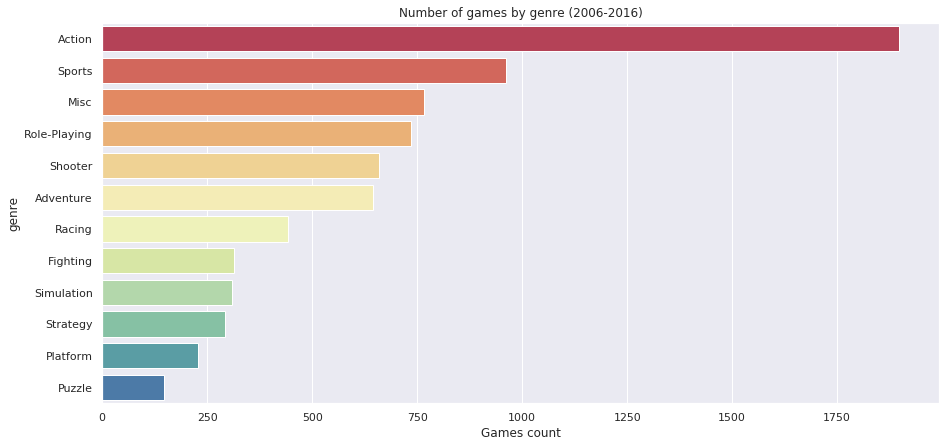

In [41]:
# считаем кол-во игр по жанрам
plot_df = hot_games.pivot_table(index='genre', values='name', aggfunc='count').sort_values('name', ascending=False).reset_index()

# посмтроим столбчатую диаграмму
plt.figure(figsize=(15,7))
ax = sns.barplot(y='genre', x='name', data=plot_df, palette='Spectral')
ax.set_xlabel('Games count')
ax.set_title('Number of games by genre (2006-2016)')

Экшоны пиу-пиу-пиу!

Посмотрим, а как продаются игры разных жанров.

Text(0.5, 1.0, 'Sales by genre (2006-2016)')

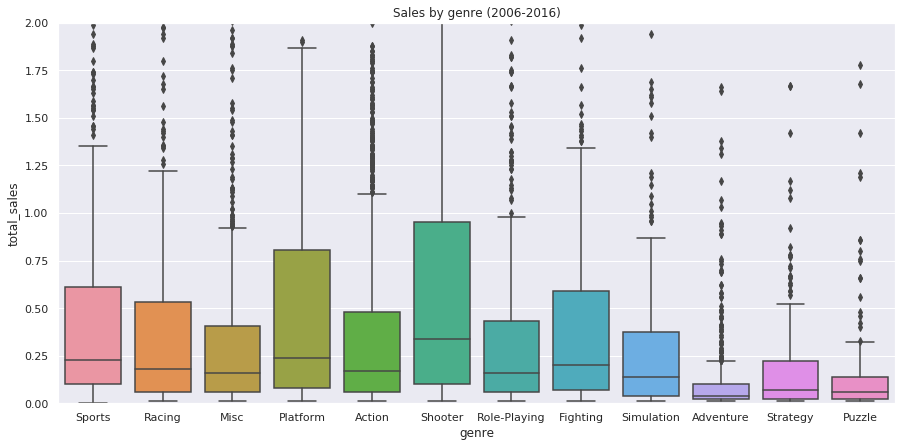

In [42]:
# построим коробки для каждого жанра по продажам
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=hot_games, y="total_sales", x="genre")

# ограничим продажи 2 млн. для наглядности
# (как мы помним, большинство игр не продаётся больше чем на 2 млн.)
ax.set_ylim([0,2])
ax.set_title('Sales by genre (2006-2016)')

Интересно, что наиболее продаваемые игры - это жанр шутер!
За ним, так же с хорошими продажами следуют Платформеры, файтинги и спортивные симуляторы.

А вот шутеры, несмотря на то, что их выпускается больше всех, продаются средне!

Самые низкие продажи у квестов, пазлов и стратегий. Думать люди, видимо, любят не сильно...:)

### Выводы.
По результатам исследовательского анализа можно сделать следующие выводы:
1. Средний срок жизни платормы на рынке составляет 10 лет. За этот срок она проходит несколько этапов: рост продаж, основное присутствие на рынке, заключительный этап ЖЦ. Наибольшие продажи, как и кол-во выпущенных игр, разумеется приходится на зону основного присутствия. При этом последние 2-3 года ЖЦ платформы, продажи игр драматически падают.
2. Исходя из оценки ЖЦ платформ и продаж, были сформулированы критерии выбора актуальных платформ на текущий год.
3. По выбранным критериям был проведён отбор актуальных платформ для 2017 года - это 5 платформ: PS4,XONE, PC, PSV, WiiU.
4. Установлено, что 99% игр не продаются больше чем на 2 млн.
5. Проанализировано влияние оценок критиков и игроков на продажи игр. Установлено, что высокие оценки критиков больше влияют на успешные продажи игры, чем оценки игроков. Это справедливо для всех платформ, кроме WiiU.
6. Проанализировано распределение игр по жанрам и оценены продажи игр разных жанров. Наиболее прибыльными можно отметить жанры Shooter, Platform и Sports. Наименее прибыльные - Adventure, Puzzle, Strategy.

## 4. Портреты пользователей каждого региона

In [43]:
# соберём данные о продажах игр по платформам для разных регионов
region_sales_df = hot_games.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales'], aggfunc='sum').reset_index()

In [44]:
region_sales_df

,platform,eu_sales,jp_sales,na_sales,other_sales,total_sales
0,3DS,61.27,100.62,82.65,13.27,257.81
1,PC,100.32,0.00,44.45,18.65,163.42
2,PS3,327.21,79.41,390.13,134.59,931.34
3,PS4,141.09,15.96,108.74,48.35,314.14
4,PSP,54.21,70.63,80.54,33.25,238.63
5,PSV,13.07,21.84,12.47,6.43,53.81
6,Wii,258.32,68.28,486.87,77.71,891.18
7,WiiU,25.13,13.01,38.10,5.95,82.19
8,X360,267.89,12.02,588.84,84.24,952.99
9,XOne,51.59,0.34,93.12,14.27,159.32


In [45]:
# напишем бомбическую функцию, которая будет всё делать за нас
# она будет брать на вход строку с регионом, считать топ платформ и жанров по продажам для этого региона
# а потом строит графики: pie-для платформ, и bar для жанров (так нагляднее)

def region_platform_top5(region):
    # берём данные только по заданному региону
    region_total_sales = region_sales_df[region].sum()
    region_df = region_sales_df[['platform',region]]
    region_df['platform_prop'] = (region_df[region] / region_total_sales)*100
    
    # составляем фрейм с топ-5 платформ по процентным долям от продаж
    top5 = region_df.sort_values('platform_prop', ascending=False).reset_index().head(5)[['platform', 'platform_prop']]  
    top5['platform_prop'] = top5['platform_prop'].round(0).astype('int')
    # добавим остальные платформы отдельно, чтобы не терять
    others_prop = 100 - top5['platform_prop'].sum()
    others = pd.Series(['other', others_prop], index=top5.columns)
    top5 = top5.append(others, ignore_index=True)
    top5['props'] = top5['platform_prop'].astype('str') + '%'
    
    #здесь посчитаем продажи по жанрам для региона, сортируем и берём топ-5
    top_genres = (hot_games
                  .pivot_table(index='genre', values=region, aggfunc='sum')
                  .sort_values(region, ascending=False)
                  .reset_index()
                  .head(5)
                 )
        
    # графики будем строить в виде двух subplot   
    fig, ax = plt.subplots(1, 2)
    
    # первый - пирожок для продаж платформ
    top5.plot(ax=ax[0],
        x='platform',
        y='platform_prop',
        labels=top5['platform'],
        kind='pie',
        autopct='%1.0f%%')
    ax[0].set_title('Top platforms for {} propositions in 2006-2016'.format(region))
    ax[0].set_axis_off()
    ax[0].legend(loc=3)
    
    # второй - топ5 жанров по продажам в регионе
    sns.barplot(ax=ax[1],
                data=top_genres,
                x=region,
                y='genre',
                palette='Spectral'
               )
    ax[1].set_title('Top 5 genres for {} in 2006-2016'.format(region))
    ax[1].set_xlabel('Sales in region, mln')
    fig.set_size_inches(18, 10)

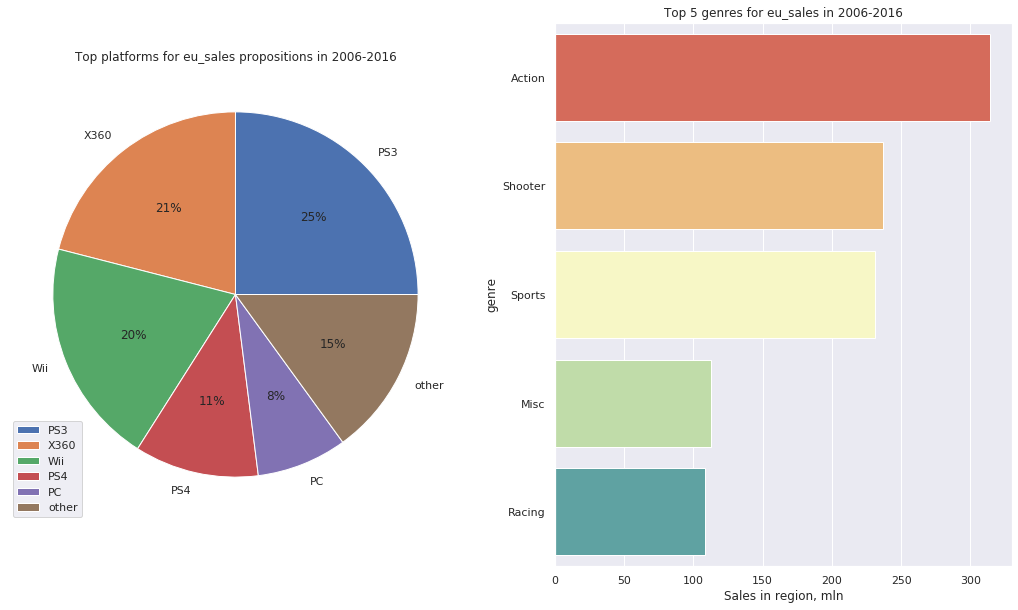

In [46]:
# посмотрим по EU
region_platform_top5('eu_sales')

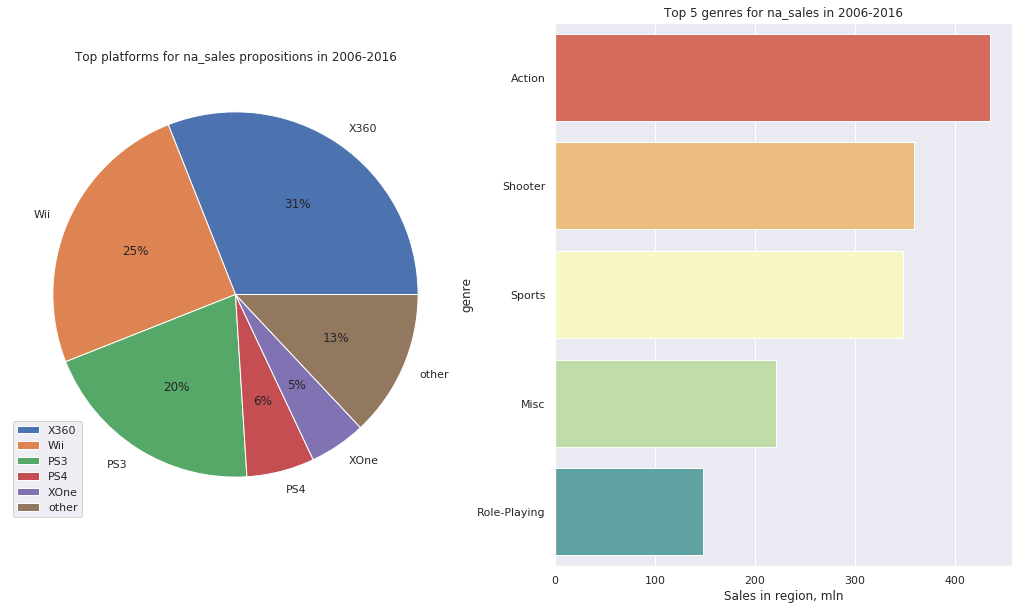

In [47]:
region_platform_top5('na_sales')

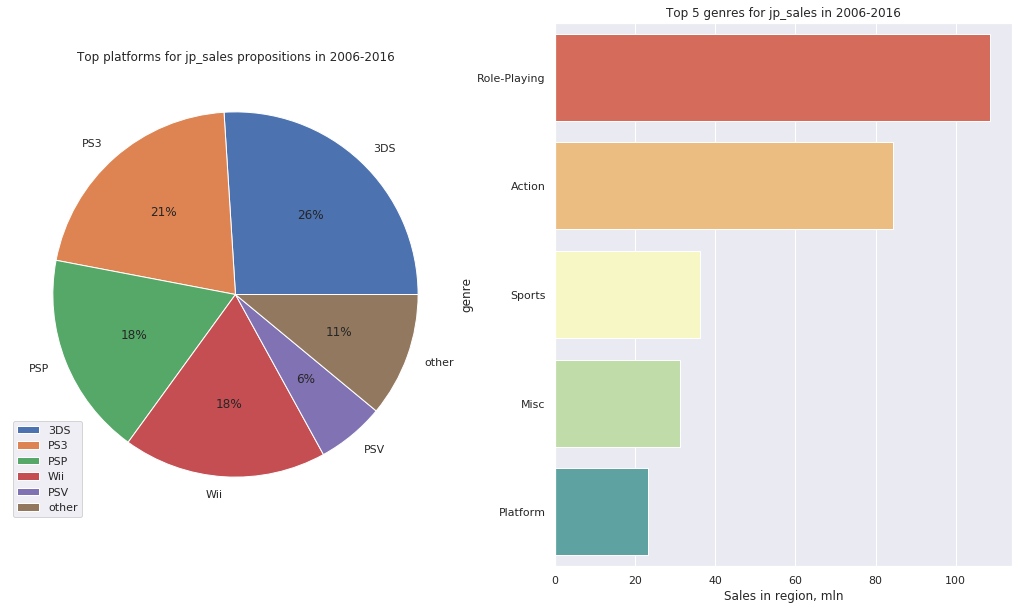

In [48]:
region_platform_top5('jp_sales')

1. Доли продаж по платформам похожи для EU и NA - более двух третьих занимают платформы PS3, X360 и Wii. Различие состоит в том, что в EU доли этих трёх платформ примерно равны, а в NA X360 неплохо опережает конкурентов.
А вот в Японии (JP) ситуация абсолютно иная. Большую часть рынка занимает приставка от Nintendo - 3DS, но также очень популярны приставки Sony (PS3,PSP,PSV). Платформы от MS (X360) в JP-регионе не популярны.

2. Касательно топа продаваемости игр разных жанров ситуация по регионам похожая. В EU и NA топ практически идентичный. Самые популярные жанры - экшон, шутеры и спорт. симуляторы.
Зато в JP самый продаваемый жанр - RPG! На втором месте - экшон. И эти два лидируют с очень большим отрывом!

Оценим, как влияет рейтинг ESRB на продажи игр в разных регионах.

Text(0.5, 1.0, 'Other sales by ESRB rating dist')

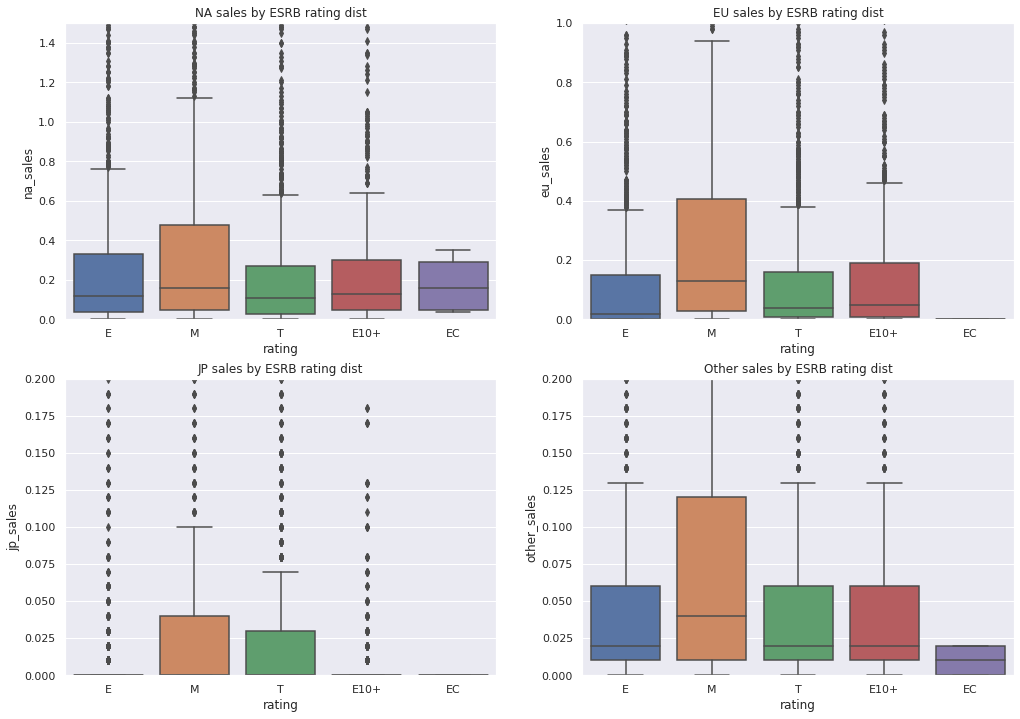

In [49]:
# посмотрим распределение продаж игр в разных регионах, в зависимости от рейтинга
# для наглядности сразу построим 4 графика в виде ящиков с усами. Так мы увидим разброс продаж по рейтингам,
# а также медианные значения продаж.
# пределы по оси были выбраны вручную в целях лучшего отображения

fig, ax = plt.subplots(2,2)
fig.set_size_inches(17, 12)

sns.boxplot(ax=ax[0,0], data=hot_games, y='na_sales', x="rating")
ax[0,0].set_ylim([0,1.5])
ax[0,0].set_title('NA sales by ESRB rating dist')

sns.boxplot(ax=ax[0,1], data=hot_games, y='eu_sales', x="rating")
ax[0,1].set_ylim([0,1])
ax[0,1].set_title('EU sales by ESRB rating dist')

sns.boxplot(ax=ax[1,0], data=hot_games, y='jp_sales', x="rating")
ax[1,0].set_ylim([0,0.2])
ax[1,0].set_title('JP sales by ESRB rating dist')

sns.boxplot(ax=ax[1,1], data=hot_games, y='other_sales', x="rating")
ax[1,1].set_ylim([0,0.2])
ax[1,1].set_title('Other sales by ESRB rating dist')

Игры "для взрослых" с рейтингом M (Mature) продаются лучше всего во всех регионах.

Также можно отметить, что игры для детей (рейтинг EC) видимо не популярны во всех регионах, кроме NA. Зато в сев. америке эти игры продаются почти так же хорошо, как и с рейтингом M.

### Выводы
Были проанализированы игровые рынки для разных регионов. 
Для каждого региона определены ТОП-5 платформ и игровых жанров по продаваемости, отмечены сходства и различия.

Также была проанализирована зависимость рейтинга ESRB на продажи игр в разных регионах.

## 5. Проверка гипотез

Необходимо статистически проверить две гипотезы:
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

---
#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза Ho: Средние оценки пользователей игр XONE равны средним оценкам игр на PC

Альтернативная гипотеза H1: Средние оценки для этих платформ не равны

In [50]:
xone_user_ratings = games_data.query('platform == "XOne"')['user_score'].dropna().reset_index(drop=True)
pc_user_ratings = games_data.query('platform == "PC"')['user_score'].dropna().reset_index(drop=True)

In [51]:
# задаём стат.значимость в 5%
alpha = 0.05

# t-test для данных, с учетом разных дисперсий
results = st.ttest_ind(
    xone_user_ratings,
    pc_user_ratings,
    equal_var=False
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.5385802963771776e-06
Отвергаем нулевую гипотезу


Вероятность справедливости нулевой гипотезы статистически мала, значит вероятна альтернативная теория: Средние пользовательские оценки для платформ XONE и PC не равны.

---
#### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Нулевая гипотеза Ho: Средние оценки пользователей игр жанра Action равны средним оценкам игр жанра Sport

Альтернативная гипотеза H1: Средние оценки для этих жанров не равны

In [52]:
action_user_ratings = games_data.query('genre == "Action"')['user_score'].dropna().reset_index(drop=True)
sports_user_ratings = games_data.query('genre == "Sports"')['user_score'].dropna().reset_index(drop=True)

In [53]:
# задаём стат.значимость в 5%
alpha = 0.05

# t-test для данных, с учетом разных дисперсий
results = st.ttest_ind(
    action_user_ratings,
    sports_user_ratings,
    equal_var=False
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.07370217419278534
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу, а значит статистически средние оценки жанров Action и Sports равны с высокой вероятностью. 

## 6. Общий вывод

В ходе работы были изучены данные о видеоиграх. Предоставленные данные содержали информацию о ~17к видеоиграх, их жанрах, продажах в различных регионах, рейтингах и тд.

Данные были предварительно проанализированы и обработаны. Приведены объяснения возможных аномалий, значения отформатированы.
Обнаруженные пропуски в данных были обработаны, даны объяснения по каким принципам это было сделано. 
Также были рассчитаны суммарные продажи игр во всех регионах.

---

В ходе исследовательского анализа, был установлен средний срок жизненного цикла платформы - 10 лет. Этот период принят за "актуальный период", т.е. определено, что данные по рынку видеоигр актуальны при рассмотрении только за последние 10 лет. 

Также были установлены основные фазы ЖЦ платформ, исходя из количества выпущенных для неё игр и продаж за соответствующие периоды. Исходя из этих данных были определены 5 платформ, которые являются перспективными для продаж игр в 2017 году:
* PS4
* XONE
* PC
* WiiU
* PSV

Проанализировано влияние оценок критиков и игроков на продажи игр. Установлено, что высокие оценки критиков больше влияют на успешные продажи игры, чем оценки игроков. Это справедливо для всех платформ, кроме WiiU.

Проанализировано распределение игр по жанрам и оценены продажи игр разных жанров. Наиболее прибыльными можно отметить жанры:
* Shooter 
* Platform
* Sports 

Наименее прибыльные: Adventure, Puzzle, Strategy.

---

Далее была составлена картина рынка видеоигр для различных регионов (NA, EU, JP).
Доли продаж по платформам для EU и NA cхожи  - более двух третьих занимают платформы PS3, X360 и Wii. Различие состоит в том, что в EU доли этих трёх платформ примерно равны, а в Серверноамериканском регионе X360 существенно опережает конкурентов. При этом в Японии, большую часть рынка занимает приставка от Nintendo - 3DS, но также очень популярны приставки Sony (PS3,PSP,PSV). Платформы от Microsoft (X360) в JP-регионе не популярны вовсе.

Анализ популярности игровых жанров для различных регионов установил, что самые популярные жанры в EU и NA - Action, Shooter и Sports. В JP самый продаваемый жанр - RPG, на втором месте - Action. Причём эти два жанра лидируют по продажам в Японии с очень большим отрывом от остальных.

Существенного влияния возрастного рейтинга ESRB на продажи игр в разных регионах не определено. Стоит отметить, что наиболее продающимися играми для всех регионов являются игры с рейтингом Mature (M). Так же установлено, что в регионе NA популярны игры для детей (рейтинг EC), хотя в других регионах эти игры почти не продаются.

---

Наконец, были выдвинуты и статистически проверены две гипотезы.
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. 

Гипотеза отвергнута.

2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Гипотеза отвергнута.